<a href="https://colab.research.google.com/github/Gr3gP/Misc-Projects/blob/main/PINNs_Overview_and_Builds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solving an ODE with a neural network

https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932

In [1]:
#we will use JAX for this implementation
import jax.numpy as np

def sigmoid(x): 
    return 1./(1. + np.exp(-x))

def f(params, x): 
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = sigmoid(x*w0 + b0)
    x = sigmoid(np.sum(x*w1) + b1)
    return x

We are using JAX here so that later on we can calculate the derivatives of f through automatic differentiation.

f has two arguments; params that are an arrray of netowork parameters, and an input value(x). 

In [2]:
#network aprams can be initialized randomly using a normal distribution
#PRNG is a pseudo-random number generator
from jax import random

key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

In [3]:
#the derivative of f with respect to x can be obtained by th e following:
from jax import grad
dfdx = grad(f, 1)

The 1 in the above code tell sus we want the gradient of f with reposect to its second argument x(zero-based indexng). Jax's `grad` will return a function that evaluated the gradient of f and has teh same arguments as the original f. 

In [4]:
#we want to solve our ODE in the domain -2<=x<=2. 
#just have to create an array of input values where 401 is an arbitrary 
#choice to have a resolution of .01 in our chosen interval

inputs = np.linspace(-2., 2., num=401)

f will however accept a single value x as input. we would pass an array but for differntiation purposes, JAX requires a saclar function. so we have to pass a single value as input in order to get a single value as output. To efficiently compute f and its derivate dfdx for an array of input values, we vectorize those functions using vmap:

In [5]:
from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))

Where `(None,0)` specifies that each function is to be mapped over the `0` axis of the second argument (`x`), while the first argument (`params`) should be left untouched (with `None`, it will be broadcasted across the mapping)

In [6]:
#we now define our loss function  
from jax import jit


@jit
def loss(params, input):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq*2) + ic**2

Note how the differential equation y’=-2xy and the initial condition y(0)=1 have been captured in eq and ic, respectively. They have been expressed as y’+2xy=0 and y(0)-1=0 in order to minimize the residuals y’+2xy and y(0)-1 during the training process. We use JIT (just-in-time compilation) on this function to speed up its execution on accelerator hardware, such as a GPU or a TPU, if available.

In [7]:
grad_loss = jit(grad(loss, 0))

Where zero means we want the gradient of the loss function with repspect to its first argument(`params`). JIT speeds up the execution. 

TO begin training, we will use gradient descent with Nezterov momentum. Nesterov Accelerated Gradient(NAG) = 

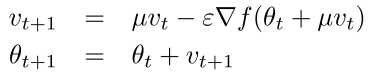

In [8]:
#implement training:
epochs =1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.434892
epoch: 100 loss: -2.502514
epoch: 200 loss: -2.503096
epoch: 300 loss: -2.504607
epoch: 400 loss: -2.512487
epoch: 500 loss: -2.536181
epoch: 600 loss: -2.578861
epoch: 700 loss: -2.489753
epoch: 800 loss: -2.424284
epoch: 900 loss: nan


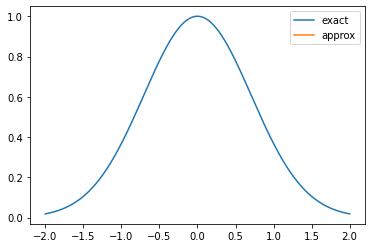

In [11]:
#run model
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

WE can see in the above plot the two lines are basically indistinguishable.

Now lets redefine our domain(inputs) and plot the model again and see how it changes.

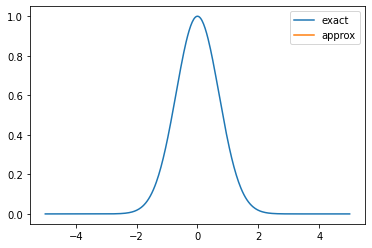

In [21]:
#redefine inputs
inputs = np.linspace(-5., 5., num=401)

#replot results

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()